# 7.5.2 Variational Autoencoders (VAE)

## Explanation of Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs) are a type of generative model that combines principles from Bayesian inference and deep learning. Unlike traditional autoencoders, which learn a deterministic mapping from input to latent space and back, VAEs learn a probabilistic mapping. This means that for each input, the encoder outputs a distribution over the latent space, rather than a single point. This probabilistic nature makes VAEs particularly powerful for generating new, unseen data.

### VAEs consist of two main components:
- **Encoder**: Maps input data to a latent space characterized by a mean and a variance.
- **Decoder**: Generates data by sampling from the latent space distribution and mapping it back to the input space.

  
## Benefits and Use Cases of VAEs

- **Generation of New Data**: VAEs can generate new data points by sampling from the latent space.
- **Dimensionality Reduction**: VAEs can learn efficient, low-dimensional representations of high-dimensional data.
- **Anomaly Detection**: VAEs can detect anomalies by measuring the reconstruction error of data points.
- **Data Imputation**: VAEs can be used to fill in missing values in datasets.


___
___
### Readings:
- [Latent Space in Deep Learning](https://www.baeldung.com/cs/dl-latent-space)
- [An Overview of Variational Autoencoders (VAEs)](https://www.analyticsvidhya.com/blog/2023/07/an-overview-of-variational-autoencoders/)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [Autoencoders, Variational Autoencoders (VAE) and β-VAE](https://medium.com/@rushikesh.shende/autoencoders-variational-autoencoders-vae-and-%CE%B2-vae-ceba9998773d)
- [Building Intuition: Variational Autoencoders (VAEs)](https://medium.com/accredian/building-intuition-variational-autoencoders-vaes-9c0908903f93)
- [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
___
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist

In [3]:
latent_dim = 16 

# Encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
mean = layers.Dense(latent_dim)(x)
log_var = layers.Dense(latent_dim)(x)
z = Sampling()([mean, log_var])
encoder = Model(encoder_inputs, [mean, log_var, z], name='encoder')

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D(2)(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')


In [4]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        mean, log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(
            log_var - tf.square(mean) - tf.exp(log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

vae = VAE(encoder, decoder)


In [5]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

vae.compile(optimizer='adam', loss='binary_crossentropy')
history = vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - loss: 0.7230 - val_loss: 0.2641
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.2638 - val_loss: 0.2637
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.2641 - val_loss: 0.2631
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - loss: 0.2629 - val_loss: 0.2630
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - loss: 0.2635 - val_loss: 0.2637
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - loss: 0.2633 - val_loss: 0.2629
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - loss: 0.2635 - val_loss: 0.2629
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - loss: 0.2634 - val_loss: 0.2632
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - loss: 0.2629 - val_loss: 0.2628
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - loss: 0.2631 - val_loss: 0.2626
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - loss: 0.2631 - val_loss: 0.2629
Epoch 12/50
469/469 ━━━━━━━━━━

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


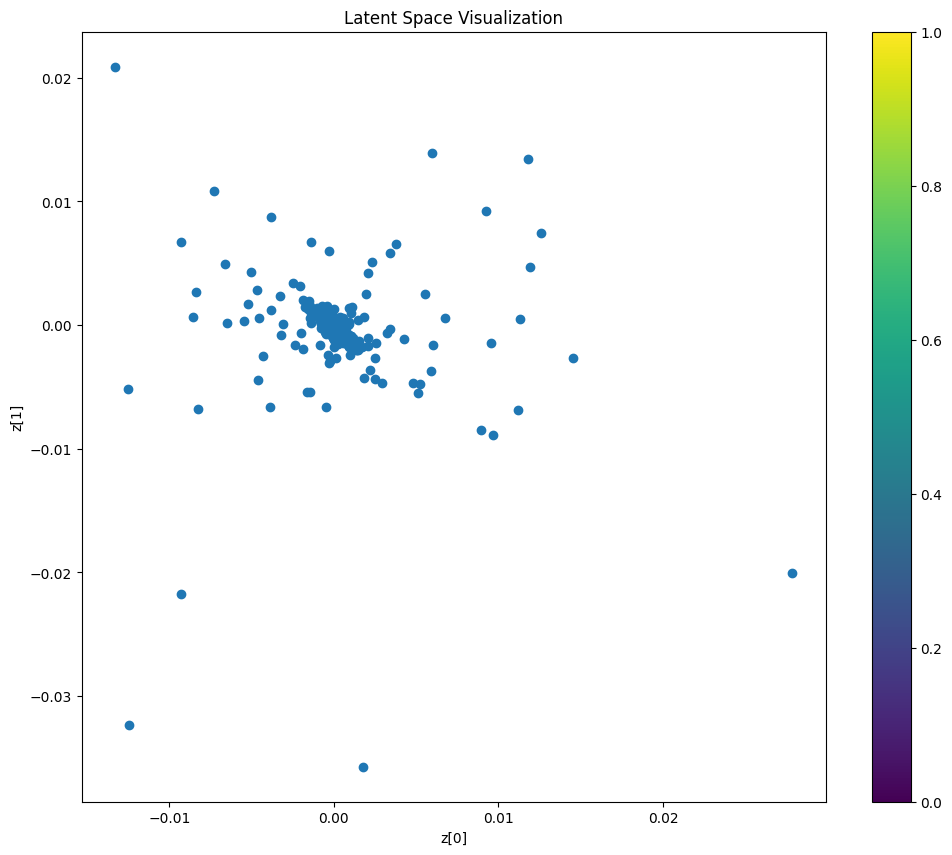

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

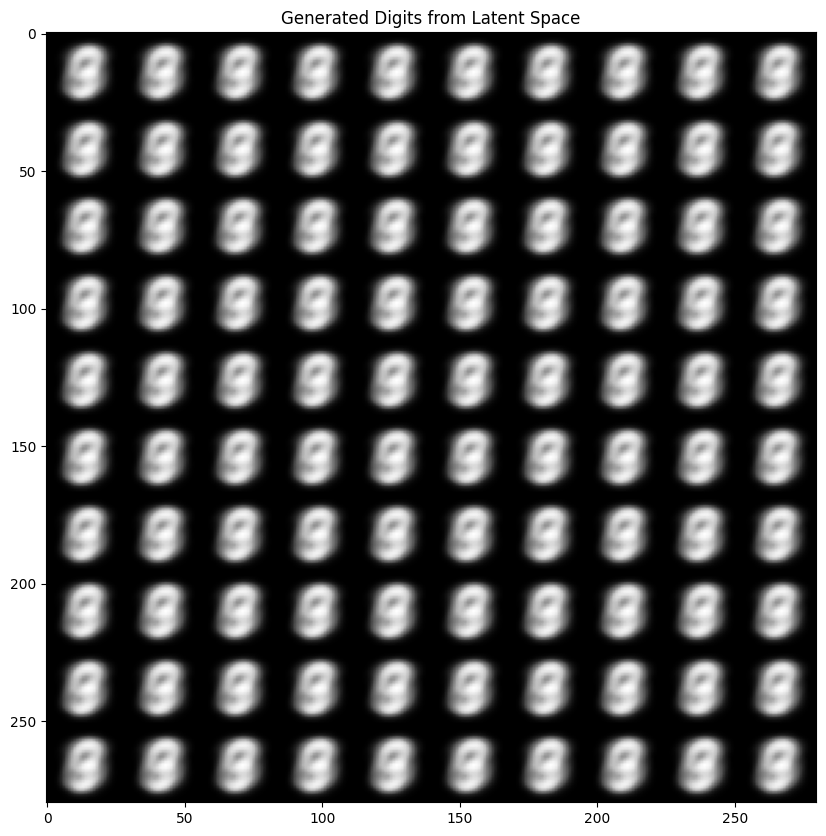

In [10]:
# Visualize the latent space
z_mean, _, _ = encoder.predict(x_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], cmap='tab10')
plt.colorbar()
plt.title("Latent Space Visualization")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

# Generate new images
def plot_latent_images(decoder, n=10, digit_size=28):
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi] + [0] * (latent_dim - 2)])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="Greys_r")
    plt.title("Generated Digits from Latent Space")
    plt.show()

plot_latent_images(decoder)


## Conclusion

Variational Autoencoders (VAEs) represent a powerful class of generative models that effectively combine probabilistic reasoning with deep learning. By learning a probabilistic mapping from input data to a latent space, VAEs excel in generating new data, reducing dimensionality, detecting anomalies, and imputing missing values. The flexibility and robustness of VAEs make them a valuable tool in various applications, from image generation to anomaly detection in complex datasets. Understanding and implementing VAEs can provide deep insights and practical solutions for modern data-driven challenges.
